<a href="https://colab.research.google.com/github/ajitkumarkp/CV/blob/master/Blemish_Removal_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face-blemish removal app
This notebook implements a simple face-blemish removal application i.e load a face-image with blemishes on it, the user clicks on the blemish and the blemish is magically gone!

Blemish removal can be accomplished in two steps.

1. Find an image patch for replacing the blemish region. The best potential patches are in the neighborhood of the blemish region because lighting and texture in this region is likely to be consistent with the blemish region.

1. Blend the patch over the blemish region.

These steps are implemented using an interactive application based on OpenCV's High-GUI framework, which enables the user to interactively click on the blemishes on the image and remove them and/or undo any changes instantly.

Note: This app cannot run on Jupyter notebook since it does not support the High-GUI module, hence it will need to be run on a desktop system. THis notebook is purely meant for documentation.


In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

size = 16  
 
def mse(imA, imB):
  val = np.sum((imA.astype("float") - imB.astype("float")) ** 2)
  val /= float(imA.shape[0] * imA.shape[1])
  return val

def compare_borders(imgA, imgB):
  upper_borderA = imgA[0:2, 0:size]
  upper_borderB = imgB[0:2, 0:size]
  upper_score = mse(upper_borderA, upper_borderB)
  
  left_borderA = imgA[2:size-2, 0:2]  
  left_borderB = imgB[2:size-2, 0:2]  
  left_score = mse(left_borderA, left_borderB)

  right_borderA = imgA[2:size-2, size-2:size]  
  right_borderB = imgB[2:size-2, size-2:size]  
  right_score = mse(right_borderA, right_borderB)
  
  bottom_borderA = imgA[size-2:size, 0:size]  
  bottom_borderB = imgB[size-2:size, 0:size]  
  bottom_score = mse(bottom_borderA, bottom_borderB)

  total= upper_score+left_score+right_score+bottom_score
  
  return total

def get_gradient(image):

  image = cv2.GaussianBlur(image, (3, 3), 0, 0)
  
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
  sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1)

  abs_sobelx = cv2.convertScaleAbs(sobelx)
  abs_sobely = cv2.convertScaleAbs(sobely)

  grad = cv2.addWeighted(abs_sobelx, 0.5, abs_sobely, 0.5, 0)
  
  return grad

def drawSquare(action, x, y, flags, userdata):
  patch = [] 
  global source

  if action==cv2.EVENT_LBUTTONDOWN:
    # color = (0,0,0)
    # thickness = 1
    # patch[0]
    patch.append(source[y-(size+8):y-int(size/2), x-(size+8):x-int(size/2)])
    # cv2.rectangle(source, (x-24, y-24), (x-8, y-8), color, thickness)
    
    # patch[1]
    patch.append(source[y-(size+8):y-int(size/2), x-int(size/2):x+int(size/2)])
    # cv2.rectangle(source, (x-8, y-24), (x+8, y-8), color, thickness)

    # patch[2]
    patch.append(source[y-(size+8):y-int(size/2), x+int(size/2):x+24])
    # cv2.rectangle(source, (x+8, y-24), (x+24, y-8), color, thickness)

    # patch[3]
    patch.append(source[y-int(size/2):y+int(size/2), x-(size+8):x-int(size/2)])
    # cv2.rectangle(source, (x-24, y-8), (x-8, y+8), color, thickness)

    # patch[4]- Blemish
    patch.append(source[y-int(size/2):y+int(size/2), x-int(size/2):x+int(size/2)])
    #cv2.rectangle(source, origin, end, color, thickness)

    # patch[5]
    patch.append(source[y-int(size/2):y+int(size/2), x+int(size/2):x+(size+8)])
    # cv2.rectangle(source, (x+8, y-8), (x+24, y+8), color, thickness)

    # patch[6]
    patch.append(source[y+int(size/2):y+(size+8), x-(size+8):x-int(size/2)])
    # cv2.rectangle(source, (x-24, y+8), (x-8, y+24), color, thickness)
    
    # patch[7]
    patch.append(source[y+int(size/2):y+(size+8), x-int(size/2):x+int(size/2)])
    # cv2.rectangle(source, (x-8, y+8), (x+8, y+24), color, thickness)
    
    # patch[8]
    patch.append(source[y+int(size/2):y+(size+8), x+int(size/2):x+(size+8)])
    # cv2.rectangle(source, (x+8, y+8), (x+24, y+24), color, thickness)


    border_score = {}
    patch_grad = {}
    patchGrad_mean = {}
    
    for i in range(9):
      border_score[i] = compare_borders(patch[4], patch[i])
      patch_grad[i] = get_gradient(patch[i])
      patchGrad_mean[i] = np.mean(patch_grad[i])
      # plt.subplot(3,3,i+1); plt.title("Patch{} Avg grad:{}".format(i,patchGrad_mean[i])); plt.imshow(patch_grad[i], cmap='gray')
    # plt.show()

    patch_grad_sorted= sorted(list(patchGrad_mean.values()))    
    best_grad_ind = [val for val, item in patchGrad_mean.items() if item == patch_grad_sorted[0]]
    sec_best_grad_ind = [val for val, item in patchGrad_mean.items() if item == patch_grad_sorted[1]]
    
    # delete the blemish's border score
    del(border_score[4])
    border_score_sorted= sorted(list(border_score.values()))    
    best_border_ind = [val for val, item in border_score.items() if item == border_score_sorted[0]]
    sec_best_border_ind = [val for val, item in border_score.items() if item == border_score_sorted[1]]

    best_border = best_border_ind[0]
    sec_best_border = sec_best_border_ind[0]
    
    best_patchID = best_border 

    # Comapre the top 2 best border and take the one with lower grad 
    if (patchGrad_mean[best_border] > patchGrad_mean[sec_best_border]):    
      best_patchID = sec_best_border
  
    # print (best_patchID)
    # print ("patchGrad_mean:", patchGrad_mean)
    # print ("patch_grad_sorted:", patch_grad_sorted)
    # print ("Best grad_index:", grad_index)
    
    # print ("border_score:", border_score)
    # print ("border_score_sorted:", border_score_sorted)
    # print ("Best border_index:", border_index)

    src = cv2.GaussianBlur(patch[best_patchID],(3,3),0,0)
    dst = source
    src_mask = 255 * np.ones(patch[best_patchID].shape,patch[best_patchID].dtype)
    center = (x,y)
    source = cv2.seamlessClone(src, dst, src_mask, center, cv2.NORMAL_CLONE)

source = cv2.imread("blemish.png",1)
# Make a dummy image, will be useful to clear the drawing
dummy = source.copy()
cv2.namedWindow("Window")

# highgui function called when mouse events occur
cv2.setMouseCallback("Window", drawSquare)
k = 0

# loop until escape character is pressed
while k!=27 :
  cv2.imshow("Window", source)
  k = cv2.waitKey(20) & 0xFF
  # Another way of cloning
  if k==99:
    source= dummy.copy()

cv2.destroyAllWindows()

# Input image
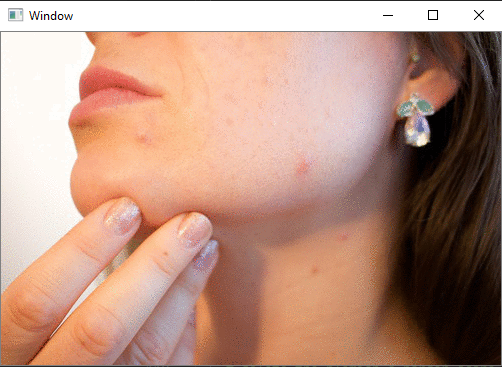

# Output image
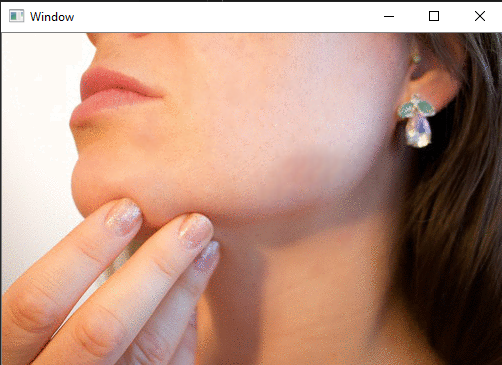